## Training the different Tic Tac Toe Players
In this notebook we will train and evaluate different players of the game Tic Tac Toe.

In [1]:
import matplotlib.pyplot as plt
from Players import RandomPlayer, MiniMaxPlayer, AlphaBetaPlayer, QPlayer, SmartPlayer
from Game import TicTacToe

import numpy as np
import torch

In [2]:
def draw(count, player1wins, player2wins, draws, player1, player2):
    plt.figure(figsize=(10,5))
    plt.ylabel('Game outcomes in %')
    plt.xlabel('Game number')

    plt.plot(count, player1wins, 'g-', label='{} wins'.format(player1.name))
    plt.plot(count, player2wins, 'b-', label='{} wins'.format(player2.name))
    plt.plot(count, draws, 'r-', label='Draw')

    plt.grid(True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,1.12), shadow=False, fancybox=True, framealpha=0.3, ncol=3)
    plt.show()
    

def train(player1, player2, rounds=10, battles=10):
    game = TicTacToe(player1, player2)
    count, player1wins, player2wins, draws = game.train(rounds, battles)
    
    draw(count, player1wins, player2wins, draws, player1, player2)
    
def test(player1, player2, rounds=10, battles=10):
    game = TicTacToe(player1, player2)
    count, player1wins, player2wins, draws = game.test(rounds, battles)

    draw(count, player1wins, player2wins, draws, player1, player2)


## 1. Using the Q table

100%|██████████| 200/200 [00:09<00:00, 20.15it/s]


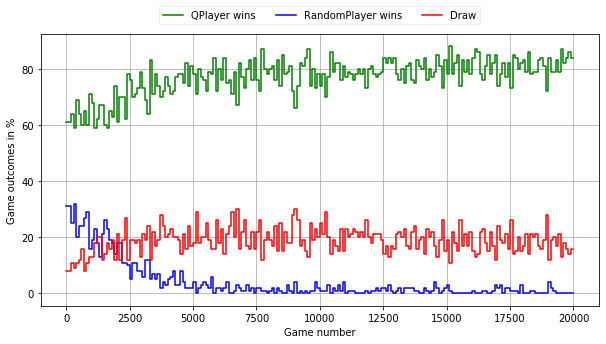

In [5]:
QPlayer1 = QPlayer(lr=0.9, lrdecay=0.95, exploration=0.1, explorationdecay=0.99)
QPlayer1.rewards = {"WINNER": 1.0, "LOSER":-1.0, "MADEDRAW":0.8, "CHOSEDRAW":0.5}

train(QPlayer1, RandomPlayer(), rounds=200, battles=100)

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


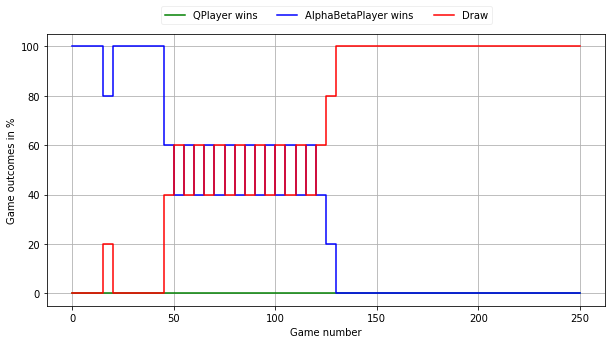

In [8]:
QPlayer2 = QPlayer(lr=0.7, lrdecay=0.95, exploration=0.3, explorationdecay=0.95)
QPlayer2.rewards = {"WINNER": 1.0, "LOSER":-1.0, "MADEDRAW":0.8, "CHOSEDRAW":0.5}

train(QPlayer2, AlphaBetaPlayer(), rounds=50, battles=5)
QPlayer2.savePolicy()

## 3. Playing against one's own

100%|██████████| 100/100 [00:04<00:00, 23.04it/s]


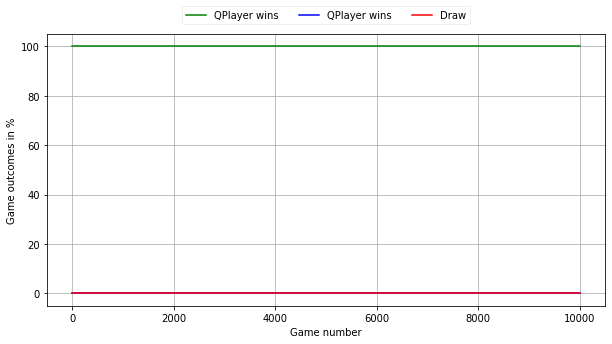

In [15]:
test(QPlayer1, QPlayer2, rounds=100, battles=100)

100%|██████████| 100/100 [00:06<00:00, 15.17it/s]


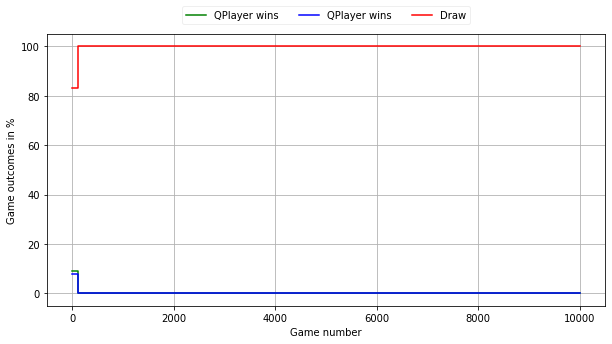

In [10]:
QPlayer3 = QPlayer(lr=0.4, lrdecay=0.9, exploration=0.2, explorationdecay=0.9)
QPlayer4 = QPlayer(lr=0.4, lrdecay=0.9, exploration=0.2, explorationdecay=0.9)

train(QPlayer3, QPlayer4, rounds=100, battles=100)

## 4. A player with a 'real' brain

100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


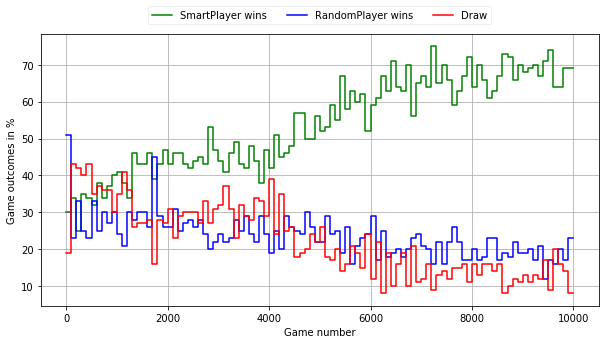

In [9]:
SmartPlayer1 = SmartPlayer(nodes=36, lr=0.1, lrdecay=1.0)
SmartPlayer1.rewards = {"WINNER": 1.0, "LOSER":0.0, "MADEDRAW":1.0, "CHOSEDRAW":0.5}

train(SmartPlayer1, RandomPlayer(), rounds=100, battles=100)
SmartPlayer1.savePolicy()


100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


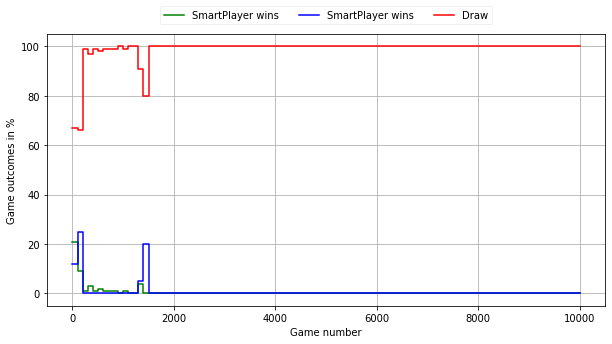

In [11]:
SmartPlayer1 = SmartPlayer(nodes=36, lr=0.1, lrdecay=1.0)
SmartPlayer2 = SmartPlayer(nodes=36, lr=0.1, lrdecay=1.0)

train(SmartPlayer1, SmartPlayer2, rounds=100, battles=100)

100%|██████████| 50/50 [00:47<00:00,  1.04it/s]


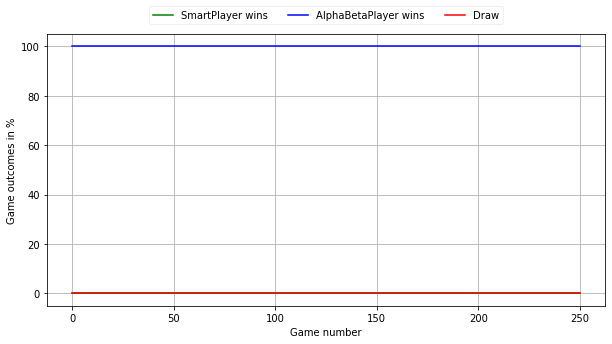

In [12]:
test(SmartPlayer2, AlphaBetaPlayer(), rounds=50, battles=5)

In [17]:
board = torch.zeros(3,3)
board[0,1] = 1
board[2,0] = board[1,0] = -1
print(board)

SmartPlayer2._activebrain(board.flatten()).reshape(3,3)

tensor([[ 0.,  1.,  0.],
        [-1.,  0.,  0.],
        [-1.,  0.,  0.]])


tensor([[0.4939, 0.4051, 0.4788],
        [0.5484, 0.4971, 0.4399],
        [0.4560, 0.4287, 0.5074]], grad_fn=<ViewBackward>)

## 5. Bayesian optimisation of the models

In [26]:
from skopt import gp_minimize

def qObjective(args):
    p1 = QPlayer(*(args))
    p2 = RandomPlayer()

    game = TicTacToe(p1, p2)
    count, p1wins, p2wins, draws = game.train(100, 5)
    return -sum(p1wins)


In [29]:
res = gp_minimize(qObjective, [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)], acq_func="LCB", n_calls=15, n_random_starts=5, noise=0.1**2)
print("lr={:.2f}, lrdecay={:.2f}, exploration={:.2f}, explorationdecay={:.2f}".format(*(res.x)))


100%|██████████| 100/100 [00:00<00:00, 422.84it/s]


lr=0.14, decay=0.90, exploration=0.55, decay=0.90


100%|██████████| 100/100 [00:04<00:00, 21.30it/s]


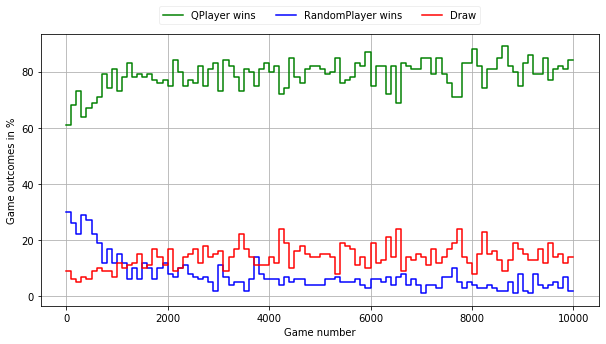

In [30]:
optimisedQPlayer = QPlayer(*(res.x))
train(optimisedQPlayer, RandomPlayer(), rounds=100, battles=100)

In [45]:
def smartObjective(args):
    p1 = SmartPlayer(*(args))
    p2 = RandomPlayer()

    game = TicTacToe(p1, p2)
    count, p1wins, p2wins, draws = game.train(100, 5)
    return -sum(p1wins) + sum(p2wins)


In [47]:
res = gp_minimize(smartObjective, [(0.0, 1.0), (0.0, 1.0)], acq_func="LCB", n_calls=10, n_random_starts=5, noise=0.1**2)
print("lr={:.2f}, lrdecay={:.2f}".format(*(res.x)))

100%|██████████| 100/100 [00:03<00:00, 26.89it/s]

lr=0.70, lrdecay=0.46


100%|██████████| 100/100 [00:04<00:00, 20.83it/s]


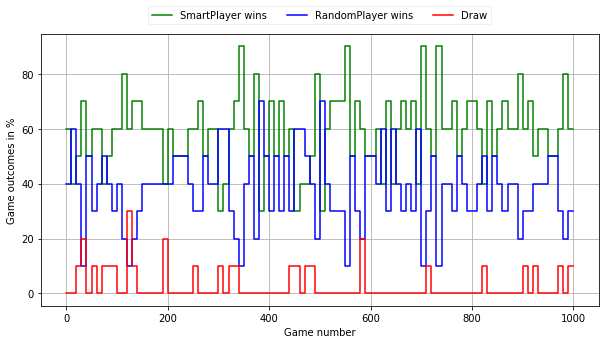

In [48]:
optimisedSmartPlayer = SmartPlayer(*(res.x))
train(optimisedSmartPlayer, RandomPlayer(), rounds=100, battles=10)